# Raw Data

### 1) Normal And Abnormal

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score


class MyNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super(MyNet, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(16, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=13)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, n_classes)
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.relu5 = nn.ReLU()
        self.relu6 = nn.ReLU()
        self.relu7 = nn.ReLU()
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        out = self.relu4(out)
        out = self.fc3(out)
        out = self.relu5(out)
        out = self.fc4(out)
        out = self.relu6(out)
        out = self.fc5(out)
        out = self.relu7(out)
        return out


class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y



In [ ]:

# Loading and preprocessing the dataset
df = pd.read_csv('dna.csv')
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Converting the data to PyTorch tensors and moving to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Creating DataLoader objects for training and testing sets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defining the model, loss function, and optimizer and moving to GPU
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 2

model = MyNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1).to(device))  # Add channel dimension and move to GPU
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs.unsqueeze(1).to(device))
        _, predicted = torch.max(outputs, dim=1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

accuracy = total_correct / total_samples
print(f'Test accuracy: {accuracy}')


Epoch 1/40, Loss: 0.28276222944259644
Epoch 2/40, Loss: 0.17944398522377014
Epoch 3/40, Loss: 0.35164767503738403
Epoch 4/40, Loss: 0.3369563817977905
Epoch 5/40, Loss: 0.08461209386587143
Epoch 6/40, Loss: 0.03885902836918831
Epoch 7/40, Loss: 0.035095393657684326
Epoch 8/40, Loss: 0.09098665416240692
Epoch 9/40, Loss: 0.036460645496845245
Epoch 10/40, Loss: 0.10519219934940338
Epoch 11/40, Loss: 0.00919918529689312
Epoch 12/40, Loss: 0.33291539549827576
Epoch 13/40, Loss: 0.17218568921089172
Epoch 14/40, Loss: 0.06807506829500198
Epoch 15/40, Loss: 0.06582272797822952
Epoch 16/40, Loss: 0.033061034977436066
Epoch 17/40, Loss: 0.012994999997317791
Epoch 18/40, Loss: 0.005882361438125372
Epoch 19/40, Loss: 0.01119986642152071
Epoch 20/40, Loss: 0.038877591490745544
Epoch 21/40, Loss: 0.012524619698524475
Epoch 22/40, Loss: 0.0006650231080129743
Epoch 23/40, Loss: 0.004419639240950346
Epoch 24/40, Loss: 0.010066579096019268
Epoch 25/40, Loss: 0.0012902480084449053
Epoch 26/40, Loss: 0.0

Test Accuracy: 0.9703
Test F1 Score: 0.9603
Test Recall: 0.9586


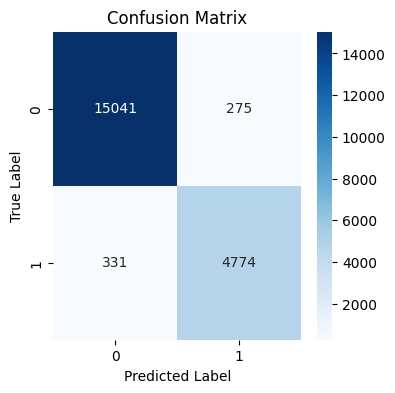

In [ ]:
total_correct = 0
total_samples = 0

# Calculating F1 score, recall, and accuracy
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, dim=1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Recall: {recall:.4f}')

# Calculating and plotting the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Saving the model
model_path = 'model_weights.pth'
torch.save(model.state_dict(), model_path)


### 2) Multiclass

In [ ]:

# Loading and preprocessing the dataset
df = pd.read_csv('dm.csv')
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Converting the data to PyTorch tensors and moving to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Creating DataLoader objects for training and testing sets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defining the model, loss function, and optimizer and moving to GPU
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 6

model = MyNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1).to(device))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/40, Loss: 0.3527626097202301
Epoch 2/40, Loss: 0.5434969067573547
Epoch 3/40, Loss: 0.5054072141647339
Epoch 4/40, Loss: 0.16663391888141632
Epoch 5/40, Loss: 0.14195501804351807
Epoch 6/40, Loss: 0.09951610118150711
Epoch 7/40, Loss: 0.1220940500497818
Epoch 8/40, Loss: 0.2782387435436249
Epoch 9/40, Loss: 0.1483549177646637
Epoch 10/40, Loss: 0.03129209205508232
Epoch 11/40, Loss: 0.6114692687988281
Epoch 12/40, Loss: 0.014949219301342964
Epoch 13/40, Loss: 0.07980766892433167
Epoch 14/40, Loss: 0.04896211996674538
Epoch 15/40, Loss: 0.10576649010181427
Epoch 16/40, Loss: 0.04599662125110626
Epoch 17/40, Loss: 0.09555036574602127
Epoch 18/40, Loss: 0.10361325740814209
Epoch 19/40, Loss: 0.25520947575569153
Epoch 20/40, Loss: 0.09610559046268463
Epoch 21/40, Loss: 0.19756542146205902
Epoch 22/40, Loss: 0.003269237233325839
Epoch 23/40, Loss: 0.23528814315795898
Epoch 24/40, Loss: 0.04217476770281792
Epoch 25/40, Loss: 0.010470883920788765
Epoch 26/40, Loss: 0.03112700581550598

Test Accuracy: 0.9667
Test F1 Score: 0.8967
Test Recall: 0.8700


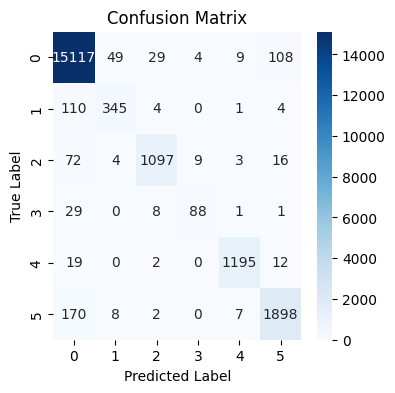

In [ ]:
total_correct = 0
total_samples = 0

# Calculating F1 score, recall, and accuracy
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, dim=1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Recall: {recall:.4f}')

# Calculating and plotting the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Saving the model
model_path = 'model_weights.pth'
torch.save(model.state_dict(), model_path)
